In [101]:
import yaml
import random
import numpy as np
import pandas as pd
from scipy.stats import entropy as scipy_entropy
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.font_manager import FontProperties
import time

POPULATION_SIZE = 200
ELITE_PROPORTION = 0.1
MUTANT_PROPORTION = 0.2
RHO_E = 0.5
MAX_GENERATION_NUMBER = 3
MAX_FITNESS = 1.0
RESTART_THRESHOLD = 10
RESTART_PROPORTION = 0.5
IMPROVEMENT_WINDOW = 20
IMPROVEMENT_EPSILON = 0.00005


RAW_DATA_FILE = "raw_data.yml"

with open(RAW_DATA_FILE, 'r', encoding="utf-8") as raw_data_file:
    RAW_DATA = yaml.safe_load(raw_data_file)

classes = RAW_DATA["classes"]
cols = RAW_DATA["course_mapping"]
rooms = RAW_DATA["rooms"]
days = RAW_DATA["days"]
hours = RAW_DATA["hours"]

LEN_ROOMS = sum(rooms["number"])
LEN_CLASSES = len(classes)
LEN_DAYS = len(days)
LEN_HOURS = len(hours)
LEN_COLS = len(cols)
LEN_ROWS = LEN_CLASSES * LEN_DAYS * LEN_HOURS
shape = (LEN_ROWS, LEN_COLS)

def check_feasibility(verbose=True):
    total_units_needed = sum([units for _, _, _, units in cols]) * LEN_CLASSES
    total_slots_available = LEN_DAYS * LEN_HOURS * LEN_ROOMS

    # Print geral
    if verbose:
        print("\n📊 Análise Geral de Viabilidade:")
        print(f"- Unidades letivas totais necessárias: {total_units_needed}")
        print(f"- Slots totais disponíveis (todas as salas): {total_slots_available}")
        print(f"- Diferença: {total_slots_available - total_units_needed} slots livres\n")

    # Verificação por tipo de sala
    room_type_to_count = {rtype: qty for rtype, qty in zip(rooms["type"], rooms["number"])}
    required_units_by_room_type = {rtype: 0 for rtype in rooms["type"]}
    available_slots_by_room_type = {}

    for subject, room_type, _, units in cols:
        required_units_by_room_type[room_type] += units * LEN_CLASSES

    if verbose:
        print("🏫 Análise por Tipo de Sala:")
    for room_type, required_units in required_units_by_room_type.items():
        available_slots = room_type_to_count[room_type] * LEN_DAYS * LEN_HOURS
        available_slots_by_room_type[room_type] = available_slots

        if verbose:
            print(f"- {room_type}:")
            print(f"   • Requerido: {required_units} slots")
            print(f"   • Disponível: {available_slots} slots")
            print(f"   • Diferença: {available_slots - required_units}\n")

        if required_units > available_slots:
            raise ValueError(
                f"Alocação impossível para salas do tipo '{room_type}':\n"
                f"Requerido = {required_units} | Disponível = {available_slots}"
            )

    # Verificação por professor
    required_units_by_professor = {}
    max_slots_per_professor = LEN_DAYS * LEN_HOURS  # 1 aula por slot

    for _, _, professor, units in cols:
        required_units_by_professor.setdefault(professor, 0)
        required_units_by_professor[professor] += units * LEN_CLASSES

    if verbose:
        print("👨‍🏫 Análise por Professor:")
    for professor, required_units in required_units_by_professor.items():
        if verbose:
            print(f"- {professor}:")
            print(f"   • Requerido: {required_units} slots")
            print(f"   • Disponível: {max_slots_per_professor}")
            print(f"   • Diferença: {max_slots_per_professor - required_units}\n")

        if required_units > max_slots_per_professor:
            raise ValueError(
                f"O professor '{professor}' tem carga horária excessiva: "
                f"{required_units} unidades letivas atribuídas, mas só há {max_slots_per_professor} slots disponíveis."
            )

    if verbose:
        print("✅ Alocação viável: recursos suficientes no total, por tipo de sala e por professor.\n")


check_feasibility()


📊 Análise Geral de Viabilidade:
- Unidades letivas totais necessárias: 444
- Slots totais disponíveis (todas as salas): 1155
- Diferença: 711 slots livres

🏫 Análise por Tipo de Sala:
- Sala:
   • Requerido: 234 slots
   • Disponível: 660 slots
   • Diferença: 426

- Lab:
   • Requerido: 210 slots
   • Disponível: 495 slots
   • Diferença: 285

👨‍🏫 Análise por Professor:
- Laura:
   • Requerido: 36 slots
   • Disponível: 55
   • Diferença: 19

- Paulo:
   • Requerido: 30 slots
   • Disponível: 55
   • Diferença: 25

- Rafaela:
   • Requerido: 36 slots
   • Disponível: 55
   • Diferença: 19

- Gustavo:
   • Requerido: 12 slots
   • Disponível: 55
   • Diferença: 43

- Paes:
   • Requerido: 54 slots
   • Disponível: 55
   • Diferença: 1

- Ana:
   • Requerido: 48 slots
   • Disponível: 55
   • Diferença: 7

- Carlos:
   • Requerido: 54 slots
   • Disponível: 55
   • Diferença: 1

- Willy:
   • Requerido: 42 slots
   • Disponível: 55
   • Diferença: 13

- Felipe:
   • Requerido: 24 slots

In [102]:
def get_entropy(individual, class_name, threshold=0.0):
    u_per_day_mat = np.zeros((LEN_COLS, LEN_DAYS), dtype=np.uint8)
    class_index = classes.index(class_name)

    for day in range(LEN_DAYS):
        for hour in range(LEN_HOURS):
            for row in range(LEN_COLS):
                idx = hour + day * LEN_HOURS + class_index * LEN_DAYS * LEN_HOURS
                if individual["genes"][idx, row] > 0:
                    u_per_day_mat[row, day] += 1

    total_entropy = 0.0
    for row in range(u_per_day_mat.shape[0]):
        row_sum = np.sum(u_per_day_mat[row, :])
        if row_sum > 0:
            entropy = scipy_entropy(u_per_day_mat[row, :], base=2)
            if entropy > threshold:
                total_entropy += entropy
    return total_entropy / LEN_COLS

def init_individual_variante(modo="combinada"):
    if modo == "aleatorio":
        keys = np.random.rand(len(cols))

    elif modo == "sala_escassa":
        dificuldade = []
        for _, room_type, _, units in cols:
            n_salas = rooms["number"][rooms["type"].index(room_type)]
            dificuldade.append(units / n_salas)
        base_order = sorted(range(len(cols)), key=lambda i: -dificuldade[i])
        keys = np.zeros(len(cols))
        for rank, col_idx in enumerate(base_order):
            keys[col_idx] = (len(cols) - rank) / len(cols)
        noise = np.random.normal(0, 0.1, len(cols))
        keys = np.clip(keys + noise, 0.0, 1.0)

    elif modo == "combinada":
        professor_counts = {}
        for _, _, prof, _ in cols:
            professor_counts[prof] = professor_counts.get(prof, 0) + 1

        prioridades = []
        for _, _, prof, units in cols:
            prioridade = 0.7 * professor_counts[prof] + 0.3 * units
            prioridades.append(prioridade)

        base_order = sorted(range(len(cols)), key=lambda i: -prioridades[i])
        keys = np.zeros(len(cols))
        for rank, col_idx in enumerate(base_order):
            keys[col_idx] = (len(cols) - rank) / len(cols)
        noise = np.random.normal(0, 0.06, len(cols))
        keys = np.clip(keys + noise, 0.0, 1.0)

    else:  # padrão por carga
        base_order = sorted(range(len(cols)), key=lambda i: -cols[i][3])
        keys = np.zeros(len(cols))
        for rank, col_idx in enumerate(base_order):
            keys[col_idx] = (len(cols) - rank) / len(cols)
        noise = np.random.normal(0, 0.05, len(cols))
        keys = np.clip(keys + noise, 0.0, 1.0)

    return keys


def init_individual():
    base_order = sorted(range(len(cols)), key=lambda i: -cols[i][3])
    keys = np.zeros(len(cols))
    for rank, col_idx in enumerate(base_order):
        keys[col_idx] = (len(cols) - rank) / len(cols)
    noise = np.random.normal(0, 0.05, len(cols))
    keys = np.clip(keys + noise, 0.0, 1.0)
    return keys

def mutate_keys(keys, gen=0, max_gen=100):
    progress = gen / max_gen
    taxa_inversao = 0.1 * (1 - progress) + 0.02 * progress
    taxa_ruido = 0.06 * (1 - progress) + 0.01 * progress
    desvio = 0.03 * (1 - progress) + 0.01 * progress

    mutated = keys.copy()
    n = len(keys)

    for _ in range(int(taxa_inversao * n)):
        i, j = random.sample(range(n), 2)
        if abs(mutated[i] - mutated[j]) < 0.15:
            mutated[i], mutated[j] = mutated[j], mutated[i]

    for i in range(n):
        if random.random() < taxa_ruido:
            mutated[i] += np.random.normal(0, desvio)

    mutated = np.clip(mutated, 0.0, 1.0)
    return mutated

def hill_climbing_melhorar_blocos(ind, max_tentativas=30):
    # Inicializa ocupação por professor e por turma
    professor_schedule = {
        (dia, hora, cols[col_idx][2])
        for row in range(LEN_ROWS)
        for col_idx in range(LEN_COLS)
        if ind["genes"][row, col_idx] > 0
        for dia in [row // (LEN_HOURS * LEN_CLASSES) % LEN_DAYS]
        for hora in [row // LEN_CLASSES % LEN_HOURS]
    }

    class_schedule = np.zeros((LEN_CLASSES, LEN_DAYS, LEN_HOURS), dtype=bool)
    for row in range(LEN_ROWS):
        dia = (row // LEN_HOURS) % LEN_DAYS
        hora = row % LEN_HOURS
        clss = row // (LEN_DAYS * LEN_HOURS)
        if any(ind["genes"][row, col] > 0 for col in range(LEN_COLS)):
            class_schedule[clss, dia, hora] = True

    # Tentativas de alocar ou completar disciplinas
    for tentativa in range(max_tentativas):
        for col_idx, (subject, room_type, lecturer, units) in enumerate(cols):
            for class_idx in range(LEN_CLASSES):
                base = class_idx * LEN_DAYS * LEN_HOURS
                already_allocated = sum(ind["genes"][base + i, col_idx] > 0 for i in range(LEN_DAYS * LEN_HOURS))

                if already_allocated >= units:
                    continue  # já está completa

                unidades_restantes = units - already_allocated

                for dia in range(LEN_DAYS):
                    for hora in range(LEN_HOURS - unidades_restantes + 1):
                        # Verifica conflitos com professor e turma
                        conflito = any(
                            (dia, hora + offset, lecturer) in professor_schedule or
                            class_schedule[class_idx, dia, hora + offset]
                            for offset in range(unidades_restantes)
                        )
                        if conflito:
                            continue

                        linhas = [base + dia * LEN_HOURS + hora + offset for offset in range(unidades_restantes)]
                        tipo_sala_idx = rooms["type"].index(room_type)
                        sala_inicio = sum(rooms["number"][:tipo_sala_idx])
                        sala_fim = sala_inicio + rooms["number"][tipo_sala_idx]

                        for room in range(sala_inicio, sala_fim):
                            if all(ind["available_room"][linha % (LEN_DAYS * LEN_HOURS), room] == 0 for linha in linhas):
                                # Aloca unidades restantes
                                for linha in linhas:
                                    ind["genes"][linha, col_idx] = room + 1
                                    ind["available_room"][linha % (LEN_DAYS * LEN_HOURS), room] = 1

                                    hora_local = (linha % (LEN_DAYS * LEN_HOURS)) % LEN_HOURS
                                    dia_local = (linha % (LEN_DAYS * LEN_HOURS)) // LEN_HOURS
                                    professor_schedule.add((dia_local, hora_local, lecturer))
                                    class_schedule[class_idx, dia_local, hora_local] = True
                                break
    return ind





def decode_individual(keys):
    chromosome = list(np.argsort(keys))
    individual = {
        "keys": keys,
        "chromosome": chromosome,
        "available_room": np.zeros((LEN_DAYS * LEN_HOURS, LEN_ROOMS), dtype=np.int8),
        "genes": np.zeros(shape, dtype=np.int32)
    }
    ind = fill_genes_brkga(individual)
    # return ind
    return hill_climbing_melhorar_blocos(ind)




def fill_genes_brkga(ind):
    professor_schedule = {}

    for working_column in ind["chromosome"]:
        subject, room_type, lecturer, units = cols[working_column]

        for clss in range(LEN_CLASSES):
            start = clss * LEN_DAYS * LEN_HOURS
            allocated_units = 0
            dias_utilizados = set()

            # Fase 1: Alocação pedagógica (blocos contínuos em até 2 dias)
            dias_ordem = list(range(LEN_DAYS))

            for dia in dias_ordem:
                if len(dias_utilizados) >= 2 and dia not in dias_utilizados:
                    continue

                for hora in range(LEN_HOURS - units + 1):
                    bloco_viavel = True
                    for offset in range(units):
                        if professor_schedule.get((dia, hora + offset, lecturer), False):
                            bloco_viavel = False
                            break

                    if not bloco_viavel:
                        continue

                    bloco_completo = True
                    for offset in range(units):
                        row = start + dia * LEN_HOURS + hora + offset
                        tmp_i = rooms["type"].index(room_type)
                        s = sum(rooms["number"][:tmp_i])
                        e = s + rooms["number"][tmp_i] - 1

                        sala_disponivel = False
                        for room in range(s, e + 1):
                            if ind["genes"][row, working_column] == 0 and ind["available_room"][row % (LEN_DAYS * LEN_HOURS), room] == 0:
                                sala_disponivel = True
                                break

                        if not sala_disponivel:
                            bloco_completo = False
                            break

                    if not bloco_completo:
                        continue

                    # Fazer a alocação real do bloco
                    for offset in range(units):
                        hora_atual = hora + offset
                        row = start + dia * LEN_HOURS + hora_atual
                        tmp_i = rooms["type"].index(room_type)
                        s = sum(rooms["number"][:tmp_i])
                        e = s + rooms["number"][tmp_i] - 1

                        for room in range(s, e + 1):
                            if ind["genes"][row, working_column] == 0 and ind["available_room"][row % (LEN_DAYS * LEN_HOURS), room] == 0:
                                ind["genes"][row, working_column] = room + 1
                                ind["available_room"][row % (LEN_DAYS * LEN_HOURS), room] = 1
                                professor_schedule[(dia, hora_atual, lecturer)] = True

                                base = row % (LEN_DAYS * LEN_HOURS)
                                for clss2 in range(LEN_CLASSES):
                                    if clss2 != clss:
                                        ind["genes"][base + clss2 * LEN_DAYS * LEN_HOURS, working_column] = -1
                                for col in range(LEN_COLS):
                                    if col != working_column:
                                        ind["genes"][row, col] = -1
                                break

                    allocated_units += units
                    dias_utilizados.add(dia)
                    break  # não precisa testar mais dias
                if allocated_units >= units:
                    break

            # Fase 2: fallback – tenta slots livres avulsos
            if allocated_units < units:
                for dia in range(LEN_DAYS):
                    for hora in range(LEN_HOURS):
                        if allocated_units >= units:
                            break
                        row = start + dia * LEN_HOURS + hora
                        if professor_schedule.get((dia, hora, lecturer), False):
                            continue

                        tmp_i = rooms["type"].index(room_type)
                        s = sum(rooms["number"][:tmp_i])
                        e = s + rooms["number"][tmp_i] - 1

                        for room in range(s, e + 1):
                            if ind["genes"][row, working_column] == 0 and ind["available_room"][row % (LEN_DAYS * LEN_HOURS), room] == 0:
                                ind["genes"][row, working_column] = room + 1
                                ind["available_room"][row % (LEN_DAYS * LEN_HOURS), room] = 1
                                professor_schedule[(dia, hora, lecturer)] = True

                                base = row % (LEN_DAYS * LEN_HOURS)
                                for clss2 in range(LEN_CLASSES):
                                    if clss2 != clss:
                                        ind["genes"][base + clss2 * LEN_DAYS * LEN_HOURS, working_column] = -1
                                for col in range(LEN_COLS):
                                    if col != working_column:
                                        ind["genes"][row, col] = -1

                                allocated_units += 1
                                break
    return ind

def get_fragmentation(individual, class_name):
    class_idx = classes.index(class_name)
    total_fragmentation = 0

    for col_idx in range(LEN_COLS):
        dias_usados = set()
        base = class_idx * LEN_DAYS * LEN_HOURS

        for dia in range(LEN_DAYS):
            for hora in range(LEN_HOURS):
                idx = base + dia * LEN_HOURS + hora
                if individual["genes"][idx, col_idx] > 0:
                    dias_usados.add(dia)

        if len(dias_usados) > 0:
            total_fragmentation += len(dias_usados)

    return total_fragmentation / LEN_COLS


def evaluate(ind):
    scheduled_units = 0
    expected_units = sum([units for _, _, _, units in cols]) * LEN_CLASSES
    unallocated_units = 0
    for col_idx, (_, _, _, units) in enumerate(cols):
        for class_idx in range(LEN_CLASSES):
            base = class_idx * LEN_DAYS * LEN_HOURS
            # allocated = sum(ind["genes"][base + i, col_idx] > 0 for i in range(LEN_DAYS * LEN_HOURS))
            # if allocated == 0:
            #     unallocated_units += units
            # scheduled_units += allocated
            allocated = sum(ind["genes"][base + i, col_idx] > 0 for i in range(LEN_DAYS * LEN_HOURS))

            if allocated >= units:
                scheduled_units += units
            else:
                scheduled_units += allocated
                unallocated_units += (units - allocated)


    percentual_alocado = scheduled_units / expected_units
    entropia_media = sum(get_entropy(ind, clss) for clss in classes) / LEN_CLASSES

    def sigmoid(x):
        return 1 / (1 + np.exp(-10 * (x - 0.5)))  # centrada em 50% alocação

    sig_entropia = sigmoid(percentual_alocado)
    sig_nao_alocadas = sigmoid(percentual_alocado)

    peso_entropia = 0.01 + 0.04 * sig_entropia
    peso_nao_alocadas = 0.25 * (1 - sig_nao_alocadas) + 0.1

    
    frag_media = sum(get_fragmentation(ind, clss) for clss in classes) / LEN_CLASSES
    peso_fragmentacao = 0.05  # Ajustável


    fitness = percentual_alocado \
          - entropia_media * peso_entropia \
          - (unallocated_units / expected_units) * peso_nao_alocadas \
          - frag_media * peso_fragmentacao


    return (fitness, percentual_alocado * 100)


def biased_crossover(parent1, parent2):
    return np.where(np.random.rand(len(parent1)) < RHO_E, parent1, parent2)

def interpolated_crossover(parent1, parent2, alpha=0.5):
    return np.clip(alpha * parent1 + (1 - alpha) * parent2 + np.random.normal(0, 0.01, len(parent1)), 0.0, 1.0)

def crossover_variavel(p1, p2):
    if random.random() < 0.7:
        return biased_crossover(p1, p2)
    else:
        return interpolated_crossover(p1, p2)
    
def torneio_binario(populacao):
    a, b = random.sample(populacao, 2)
    return a if evaluate(a)[0] > evaluate(b)[0] else b

    


def run_brkga():
    modos = ["combinada", "carga", "aleatorio"]
    population = [
        decode_individual(init_individual_variante(random.choice(modos)))
        for _ in range(POPULATION_SIZE)
    ]

    best_solution = None
    best_fitness = -np.inf
    stagnation_counter = 0
    fitness_history = []

    for generation in range(MAX_GENERATION_NUMBER):
        population.sort(key=lambda ind: evaluate(ind)[0], reverse=True)
        elites = population[:int(ELITE_PROPORTION * POPULATION_SIZE)]
        mutants = [decode_individual(init_individual()) for _ in range(int(MUTANT_PROPORTION * POPULATION_SIZE))]
        offspring = []
        while len(offspring) < POPULATION_SIZE - len(elites) - len(mutants):
            # elite_parent = random.choice(elites)
            # non_elite_parent = random.choice(population[len(elites):])
            elite_parent = torneio_binario(elites)
            non_elite_parent = torneio_binario(population[len(elites):])

            # child_keys = biased_crossover(elite_parent["keys"], non_elite_parent["keys"])
            child_keys = crossover_variavel(elite_parent["keys"], non_elite_parent["keys"])
            child_keys = mutate_keys(child_keys, generation, MAX_GENERATION_NUMBER)
            # offspring.append(decode_individual(child_keys))
            child = decode_individual(child_keys)
            child_fitness = evaluate(child)[0]
            worst_fitness = evaluate(population[-1])[0]

            # Adiciona apenas se for competitivo
            if child_fitness > worst_fitness or random.random() < 0.1:
                offspring.append(child)

        population = elites + offspring + mutants
        current_best = population[0]
        current_fitness, allocation_pct = evaluate(current_best)
        fitness_history.append(current_fitness)
        if len(fitness_history) > IMPROVEMENT_WINDOW:
            fitness_history.pop(0)

        print(f"Geração {generation + 1}: Fitness = {current_fitness:.4f} | Alocação = {allocation_pct:.2f}%")
        if current_fitness > best_fitness:
            best_solution = current_best
            best_fitness = current_fitness
            stagnation_counter = 0
        else:
            stagnation_counter += 1
        if stagnation_counter >= RESTART_THRESHOLD:
            replace_n = int(RESTART_PROPORTION * POPULATION_SIZE)
            modos = ["combinada", "carga", "aleatorio", "sala_escassa"]
            novos = []
            for _ in range(replace_n):
                modo = random.choices(modos, weights=[0.5, 0.3, 0.1, 0.1])[0]
                keys = init_individual_variante(modo)
                novos.append(decode_individual(keys))
            population[-replace_n:] = novos
            print("Reinicialização parcial da população.")
            stagnation_counter = 0
        if best_fitness >= MAX_FITNESS:
            break
        if len(fitness_history) == IMPROVEMENT_WINDOW:
            delta = max(fitness_history) - min(fitness_history)
            if delta < IMPROVEMENT_EPSILON:
                print(f"📉 Convergência detectada: variação de fitness < {IMPROVEMENT_EPSILON}")
                break
    
    print("\n📌 Diagnóstico Final da Melhor Solução Encontrada:")
    report_unallocated_classes_diagnostic(best_solution)

    return best_solution


# best = run_brkga()

In [106]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

tab20 = ListedColormap(plt.cm.tab20.colors)
subject_color_mapping = {}

# Pega todos os nomes únicos das disciplinas
all_subjects = list({col[0] for col in cols})

# Mapeia cada disciplina para uma cor
for idx, subject in enumerate(all_subjects):
    subject_color_mapping[subject] = tab20(idx % 20)


def plot_time_table(time_table, title):
    fig, ax = plt.subplots(figsize=(14, len(hours)))
    ax.set_title(title, fontsize=20)
    ax.axis('off')

    cell_text = [
        [val.replace(',', '\n') if isinstance(val, str) else '' for val in row]
        for row in time_table.values
    ]

    color_array = [
        [subject_color_mapping.get(val.split(',')[0].strip(), 'white') if isinstance(val, str) else 'white'
         for val in row]
        for row in time_table.values
    ]

    table = ax.table(
        cellText=cell_text,
        cellLoc='center',
        colLabels=time_table.columns,
        rowLabels=time_table.index,
        cellColours=color_array,
        bbox=[0, 0, 1, 1]
    )

    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.2, 1.5)

    for (row, col), cell in table.get_celld().items():
        if row == 0 or col == -1:
            cell.set_text_props(fontproperties=FontProperties(weight='bold'))
        else:
            text = cell.get_text().get_text()
            if text:
                parts = text.split("\n")
                first_part = parts[0]
                remaining_part = ' - '.join(parts[1:])
                cell.get_text().set_text(first_part + '\n\n' + remaining_part)

    plt.tight_layout()
    plt.show()




def get_time_table(individual, class_name):
    time_table = pd.DataFrame(index=hours, columns=days)
    class_idx = classes.index(class_name)

    for day_idx, day_name in enumerate(days):
        for hour_idx, hour_label in enumerate(hours):
            gene_index = hour_idx + day_idx * LEN_HOURS + class_idx * LEN_DAYS * LEN_HOURS
            for col_idx in range(LEN_COLS):
                if individual["genes"][gene_index, col_idx] > 0:
                    subject, room_type, lecturer, _ = cols[col_idx]
                    room_type_idx = rooms["type"].index(room_type)
                    room_offset = sum(rooms["number"][:room_type_idx])
                    room_number = individual["genes"][gene_index, col_idx] - 1 - room_offset
                    value = f"{subject}, {lecturer}, {room_type}{room_number + 1}"

                    # Preenche apenas se ainda estiver vazio
                    if pd.isna(time_table.loc[hour_label, day_name]):
                        time_table.loc[hour_label, day_name] = value
                    break  # uma alocação por slot é suficiente

    return time_table


In [104]:
def report_unallocated_classes_diagnostic(individual):
    print("\n📋 Relatório Detalhado de Disciplinas Não Alocadas:\n")
    has_unallocated = False

    for class_idx, class_name in enumerate(classes):
        for col_idx, (subject, room_type, lecturer, units) in enumerate(cols):
            base = class_idx * LEN_DAYS * LEN_HOURS
            allocated = sum(individual["genes"][base + i, col_idx] > 0 for i in range(LEN_DAYS * LEN_HOURS))
            
            if allocated < units:
                has_unallocated = True
                print(f"❌ {class_name}: {subject} com {lecturer} – {allocated}/{units} unidades alocadas")

                # Diagnóstico
                slots_livres = 0
                conflito_sala = 0
                conflito_prof = 0

                for day in range(LEN_DAYS):
                    for hour in range(LEN_HOURS):
                        row = base + day * LEN_HOURS + hour
                        tmp_i = rooms["type"].index(room_type)
                        s = sum(rooms["number"][:tmp_i])
                        e = s + rooms["number"][tmp_i]

                        sala_disponivel = False
                        for room in range(s, e):
                            if individual["available_room"][row % (LEN_DAYS * LEN_HOURS), room] == 0:
                                sala_disponivel = True
                                break

                        if sala_disponivel:
                            slots_livres += 1
                            # Checa se o professor está ocupado
                            for col2_idx, (_, _, prof2, _) in enumerate(cols):
                                if prof2 == lecturer and individual["genes"][row, col2_idx] > 0:
                                    conflito_prof += 1
                                    break
                        else:
                            conflito_sala += 1

                print(f"   🔍 Diagnóstico:")
                print(f"   • Slots com sala disponível: {slots_livres}")
                print(f"   • Conflitos de professor: {conflito_prof}")
                print(f"   • Conflitos de sala: {conflito_sala}\n")

    if not has_unallocated:
        print("✅ Todas as disciplinas foram alocadas com sucesso!")


# report_unallocated_classes(best)

In [98]:
import time
import pandas as pd
import matplotlib.pyplot as plt

def benchmark_brkga(n_execucoes=5):
    resultados = []
    for i in range(n_execucoes):
        print(f"\n🏁 Execução {i + 1}")
        start = time.time()
        best = run_brkga()
        tempo = time.time() - start
        fitness, alocacao = evaluate(best)
        resultados.append({
            "execucao": i + 1,
            "fitness": fitness,
            "alocacao": alocacao,
            "tempo_execucao": tempo
        })
    return pd.DataFrame(resultados)

df_resultados = benchmark_brkga(n_execucoes=1)

# 📊 Estatísticas Resumidas
print("\n📊 Estatísticas dos Resultados:")
print(df_resultados.describe())

# 📈 Boxplot do fitness final
plt.figure(figsize=(8, 5))
plt.boxplot(df_resultados["fitness"])
plt.title("Distribuição do Fitness Final nas Execuções")
plt.ylabel("Fitness")
plt.grid(True)
plt.show()

# 📈 Boxplot da taxa de alocação
plt.figure(figsize=(8, 5))
plt.boxplot(df_resultados["alocacao"])
plt.title("Distribuição da Taxa de Alocação (%)")
plt.ylabel("Taxa de Alocação (%)")
plt.grid(True)
plt.show()

# 📈 Boxplot do tempo de execução
plt.figure(figsize=(8, 5))
plt.boxplot(df_resultados["tempo_execucao"])
plt.title("Distribuição do Tempo de Execução (s)")
plt.ylabel("Tempo (segundos)")
plt.grid(True)
plt.show()


🏁 Execução 1


KeyboardInterrupt: 

In [ ]:
best = run_brkga()


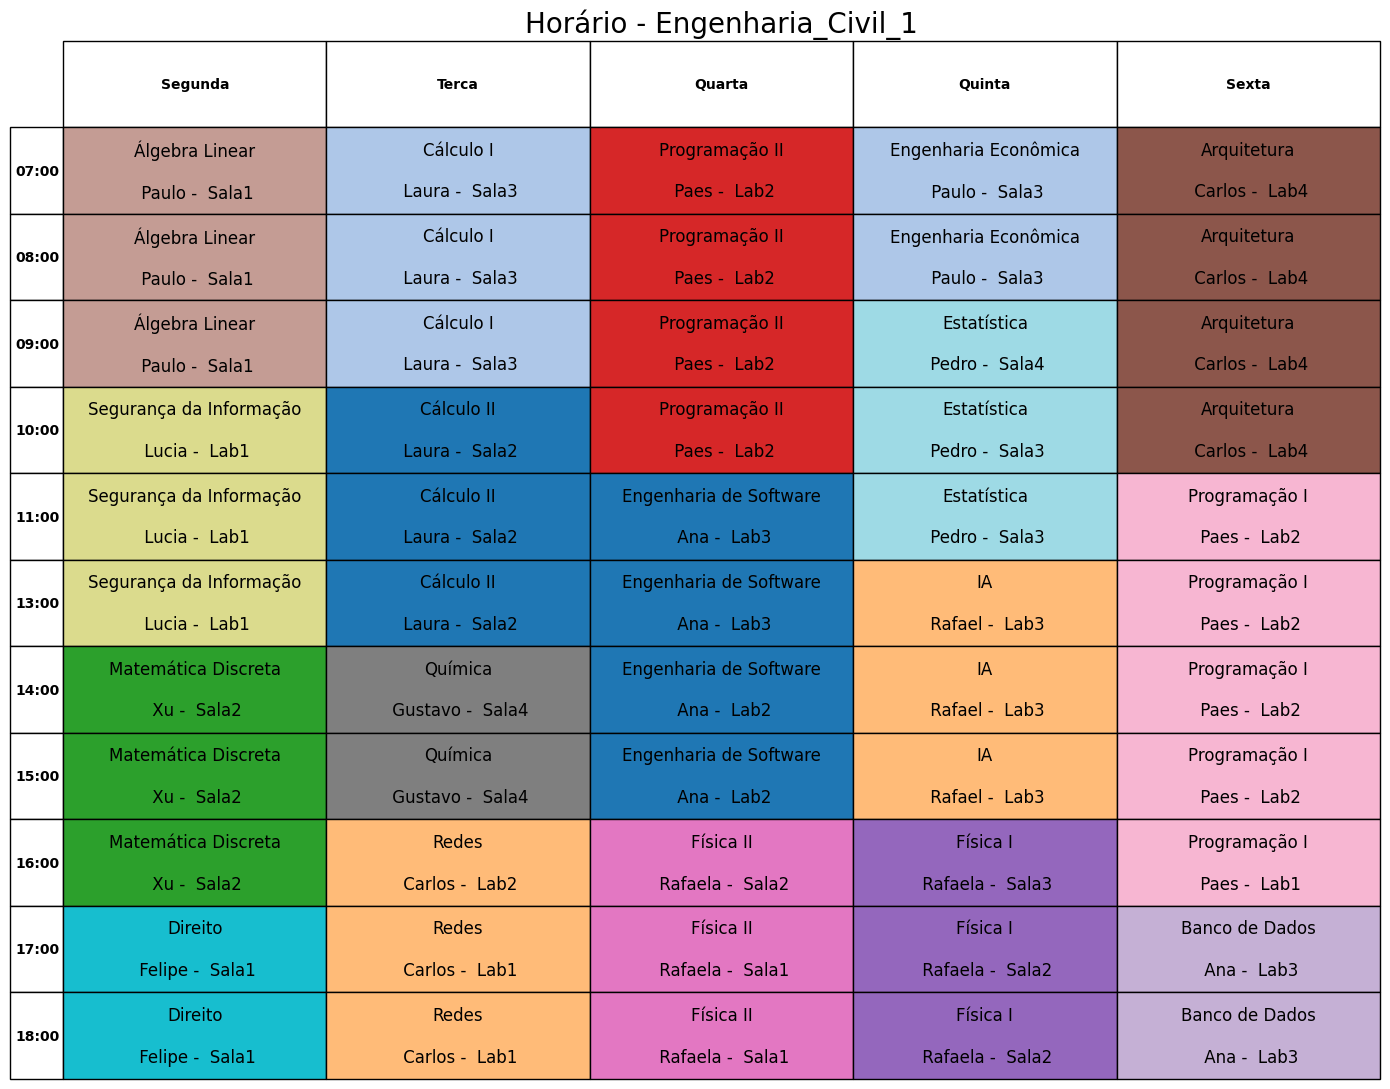

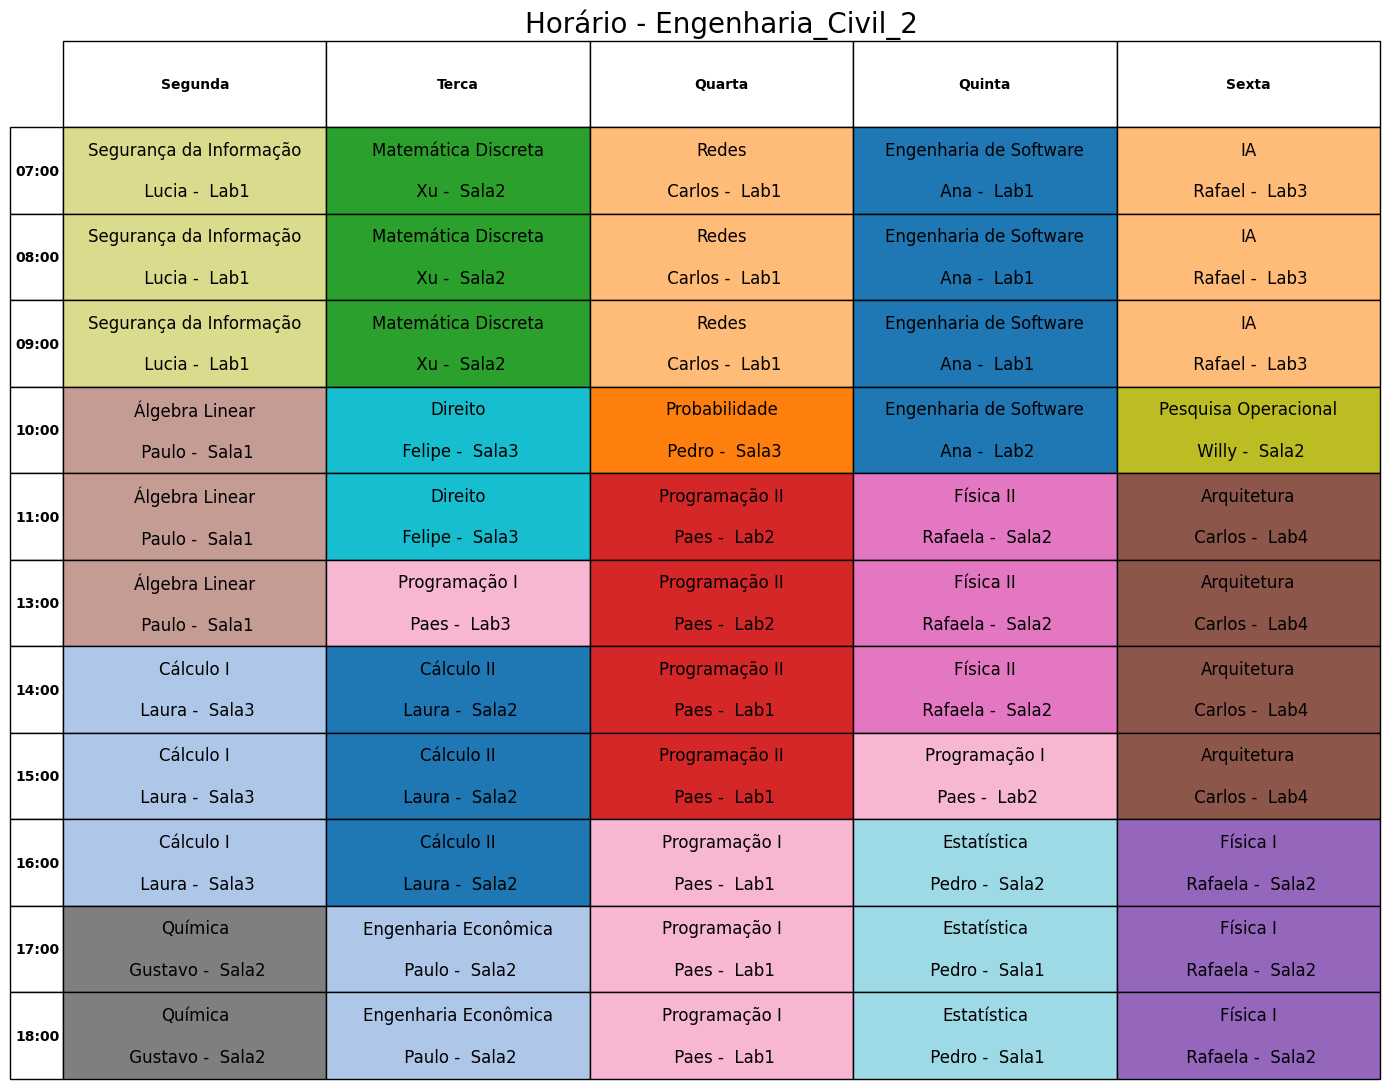

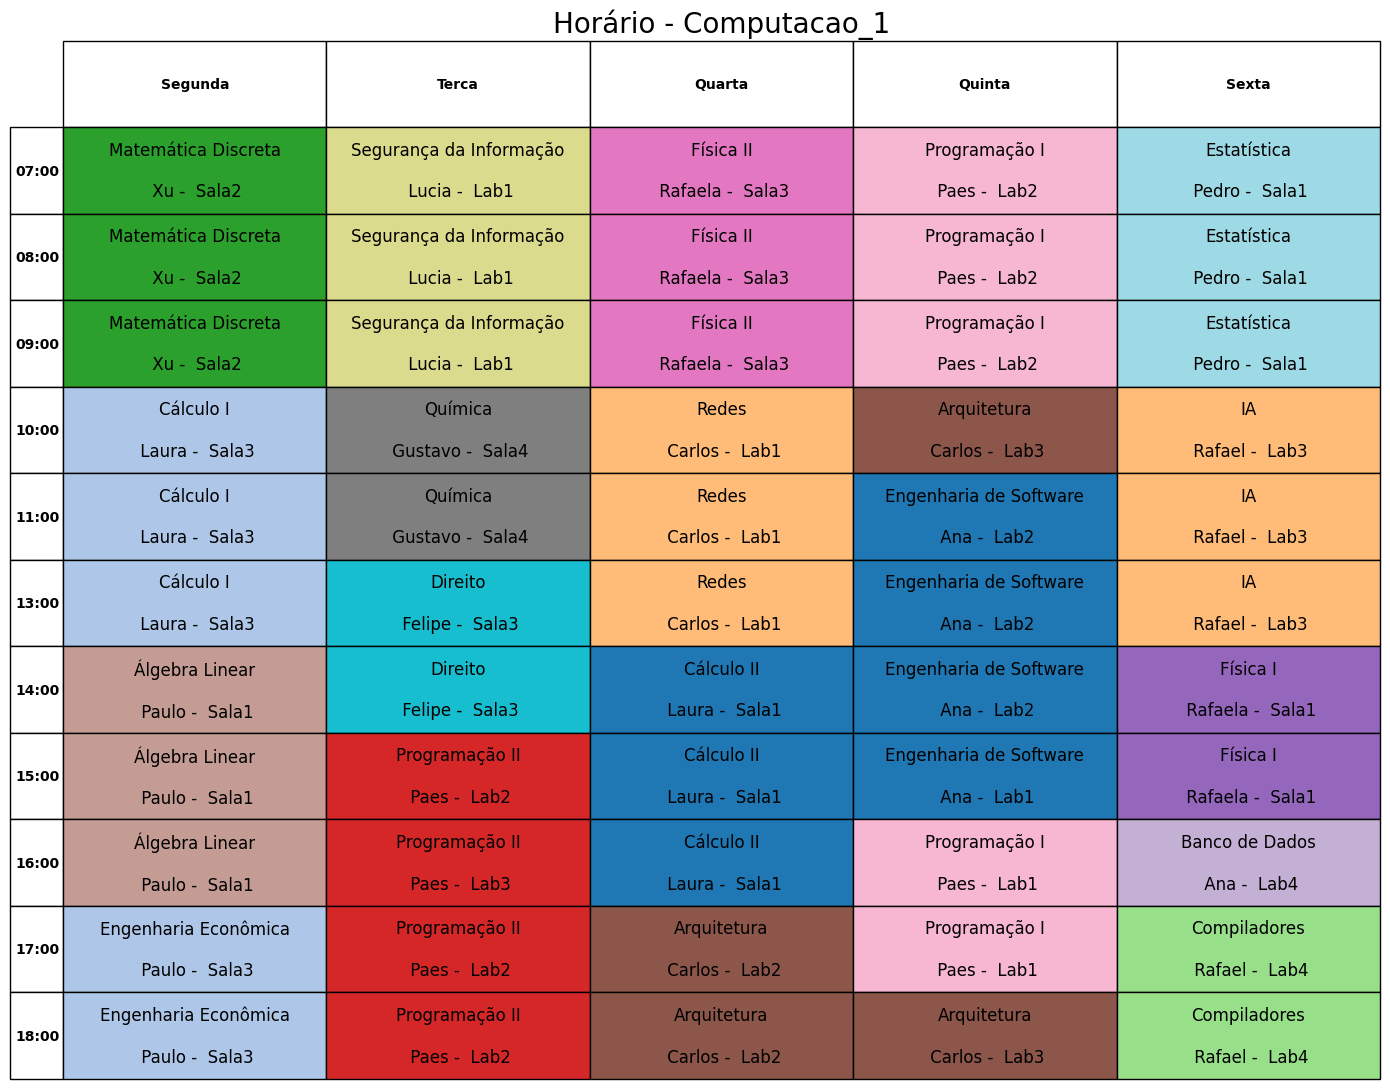

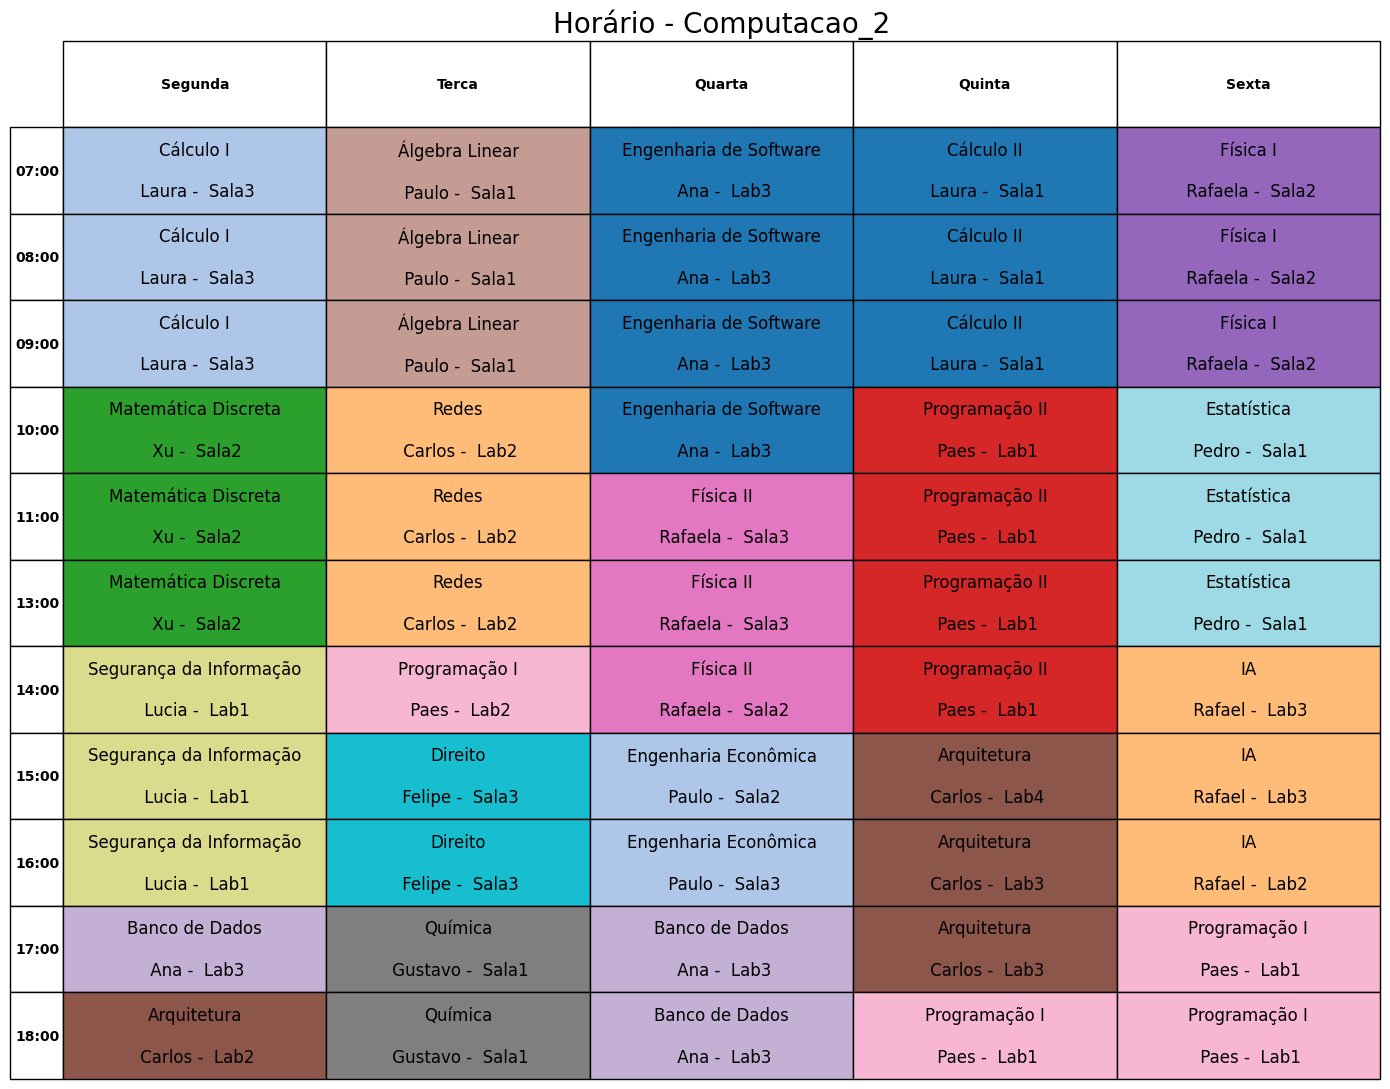

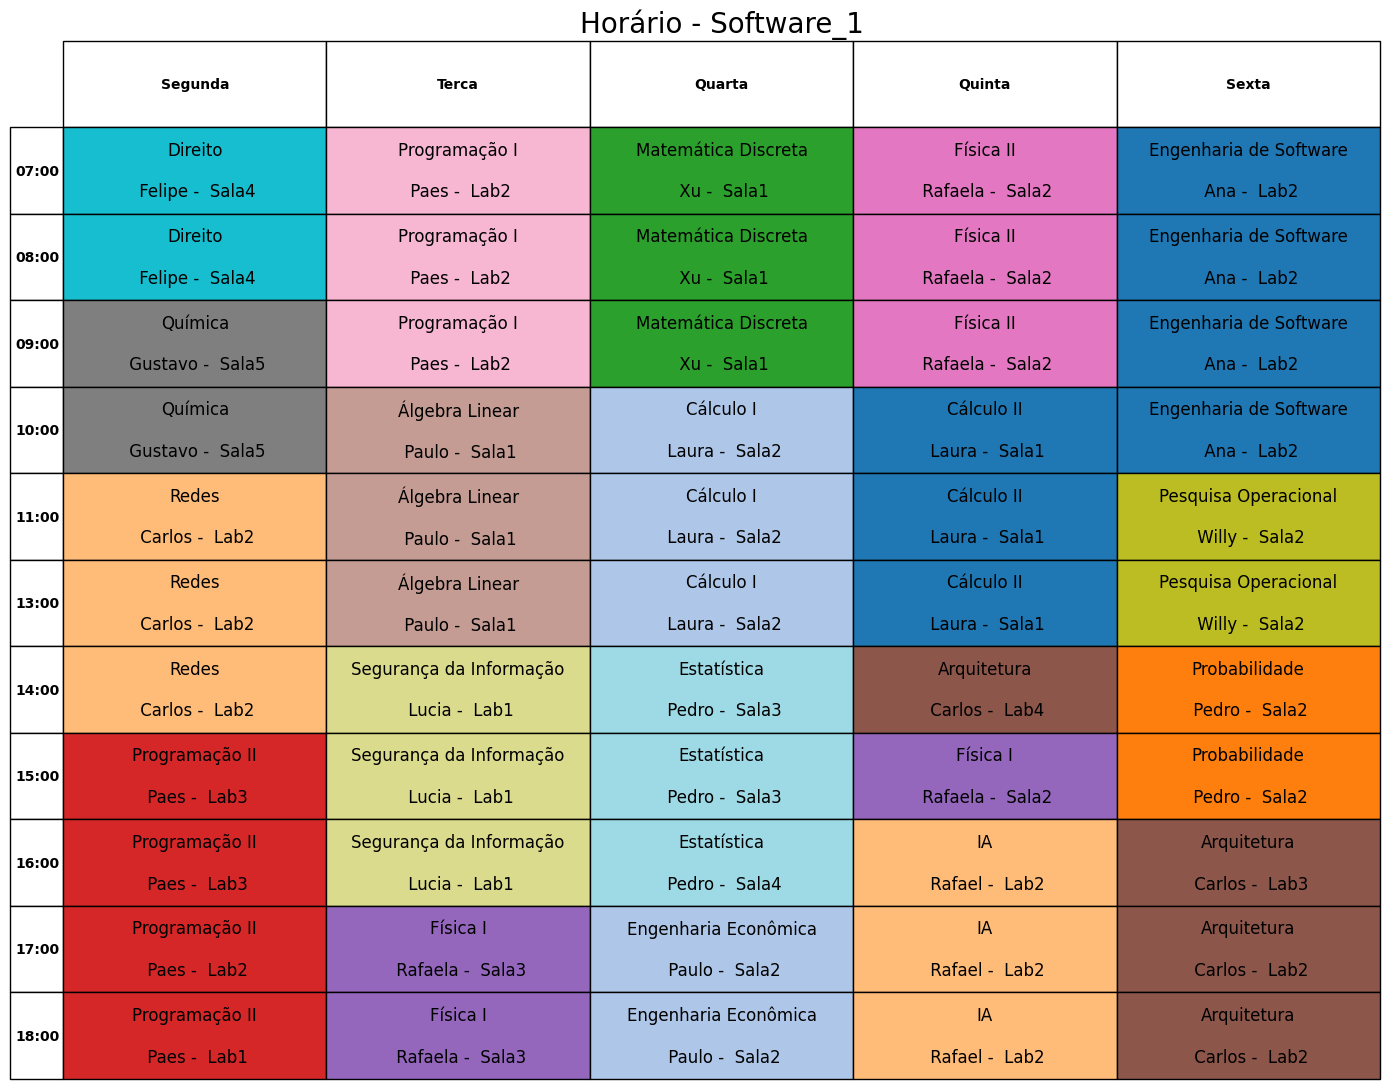

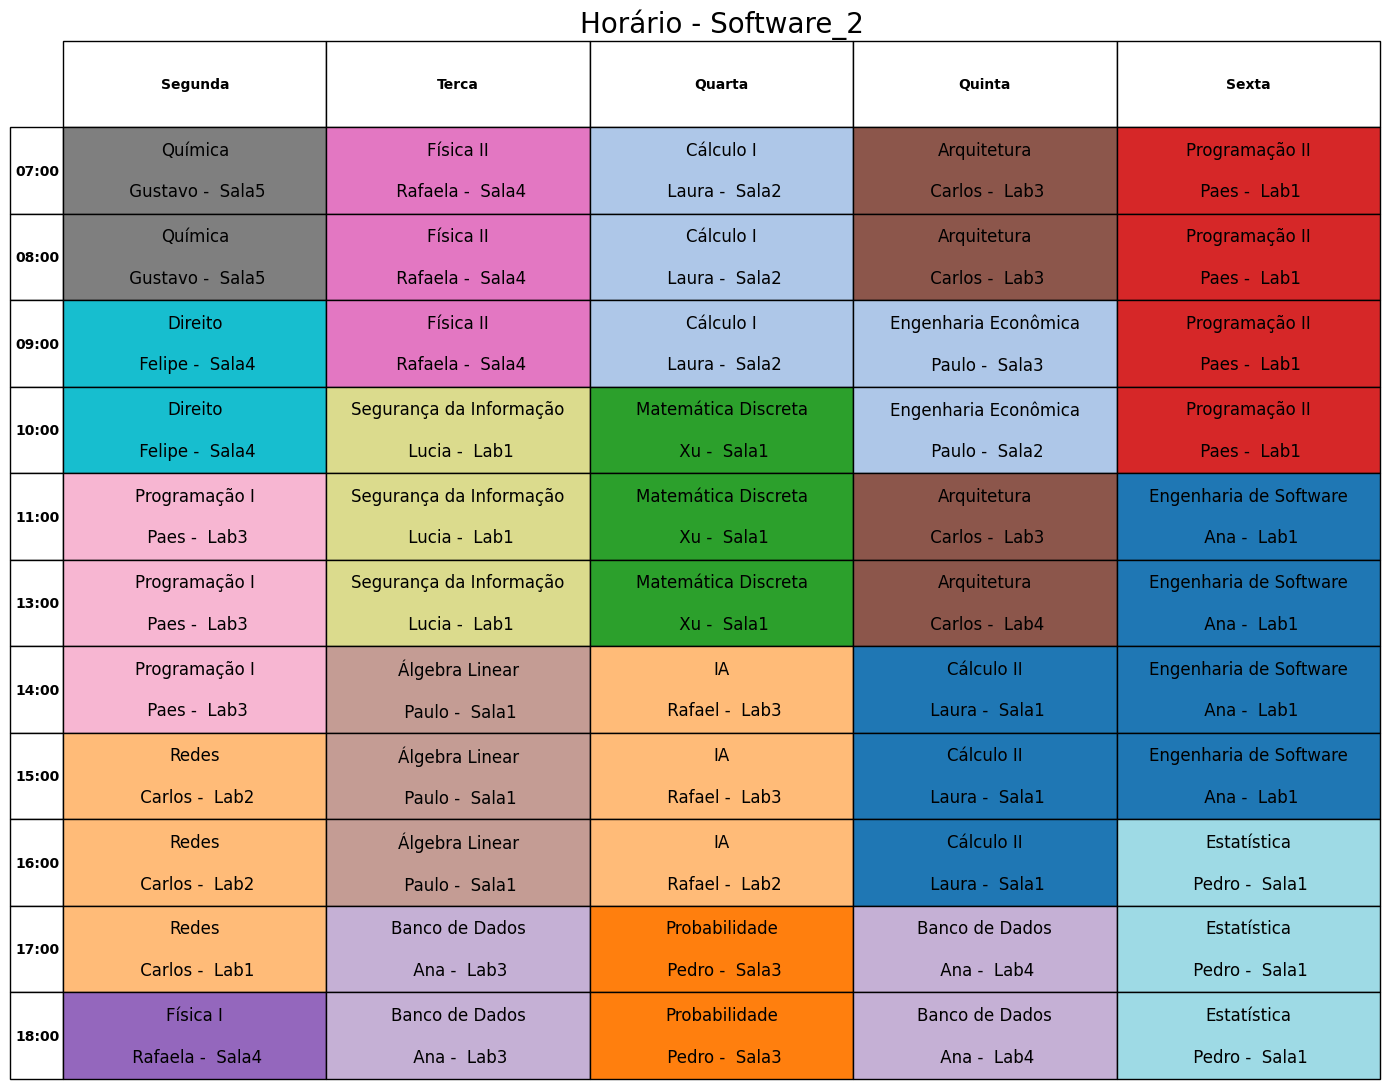

In [107]:
for class_name in classes:
    timetable = get_time_table(best, class_name)
    plot_time_table(timetable, title=f"Horário - {class_name}")

In [100]:
# Checagem de sobreposição de disciplinas
for dia in days:
    for hora in hours:
        cell = timetable.loc[hora, dia]
        if isinstance(cell, str) and cell.count('\n') > 0:
            print(f"⚠️ Conflito detectado em {dia} às {hora}:")
            print(cell)
